# Imports

In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import warnings
pd.set_option('display.max_columns', None)

# Suppress overflow warnings from sklearn/numpy
warnings.filterwarnings("ignore", category=RuntimeWarning)
np.seterr(over='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

# Load Dataset

In [2]:
pitching_data = pd.read_csv('PaulSkenes_data.csv') # Load CSV

pitching_data.head() 

,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,spin_dir,spin_rate_deprecated,break_angle_deprecated,break_length_deprecated,zone,des,game_type,stand,p_throws,home_team,away_team,type,hit_location,bb_type,balls,strikes,game_year,pfx_x,pfx_z,plate_x,plate_z,on_3b,on_2b,on_1b,outs_when_up,inning,inning_topbot,hc_x,hc_y,tfs_deprecated,tfs_zulu_deprecated,umpire,sv_id,vx0,vy0,vz0,ax,ay,az,sz_top,sz_bot,hit_distance_sc,launch_speed,launch_angle,effective_speed,release_spin_rate,release_extension,game_pk,fielder_2,fielder_3,fielder_4,fielder_5,fielder_6,fielder_7,fielder_8,fielder_9,release_pos_y,estimated_ba_using_speedangle,estimated_woba_using_speedangle,woba_value,woba_denom,babip_value,iso_value,launch_speed_angle,at_bat_number,pitch_number,pitch_name,home_score,away_score,bat_score,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment,spin_axis,delta_home_win_exp,delta_run_exp,bat_speed,swing_length,estimated_slg_using_speedangle,delta_pitcher_run_exp,hyper_speed,home_score_diff,bat_score_diff,home_win_exp,bat_win_exp,age_pit_legacy,age_bat_legacy,age_pit,age_bat,n_thruorder_pitcher,n_priorpa_thisgame_player_at_bat,pitcher_days_since_prev_game,batter_days_since_prev_game,pitcher_days_until_next_game,batter_days_until_next_game,api_break_z_with_gravity,api_break_x_arm,api_break_x_batter_in,arm_angle,attack_angle,attack_direction,swing_path_tilt,intercept_ball_minus_batter_pos_x_inches,intercept_ball_minus_batter_pos_y_inches
0,FF,2025-09-16,97.8,-2.41,5.51,"Skenes, Paul",663538,694973,single,hit_into_play,NaN,NaN,NaN,NaN,11,Nico Hoerner singles on a ground ball to short...,R,R,R,PIT,CHC,X,6.0,ground_ball,1,2,2025,-1.26,0.80,-0.70,3.69,NaN,NaN,683737.0,2,4,Top,121.94,146.8,NaN,NaN,NaN,NaN,7.594717,-142.271914,-1.250416,-18.861630,33.677830,-21.208311,3.31,1.55,53.0,55.1,5.0,98.5,2332,6.8,776308,680779,687462,694377,669707,693304,669261,665833,672744,53.73,0.091,0.097,0.9,1.0,1.0,0.0,1.0,33,7,4-Seam Fastball,1,3,3,1,3,1,3,1,Standard,Strategic,239,-0.015,0.439,63.2,5.8,0.104,-0.439,88.0,-2,2,0.281,0.719,23,28,23,28,3,2,6.0,1.0,NaN,1.0,1.59,1.26,1.26,20.4,3.667252,10.051646,19.332678,26.925733,19.079675
1,SL,2025-09-16,86.2,-2.31,5.43,"Skenes, Paul",663538,694973,NaN,ball,NaN,NaN,NaN,NaN,14,Nico Hoerner singles on a ground ball to short...,R,R,R,PIT,CHC,B,NaN,NaN,0,2,2025,0.67,0.65,2.33,1.72,NaN,NaN,683737.0,2,4,Top,NaN,NaN,NaN,NaN,NaN,NaN,9.722977,-125.097757,-3.848883,4.818483,27.771388,-24.736055,3.21,1.45,NaN,NaN,NaN,86.5,2075,6.8,776308,680779,687462,694377,669707,693304,669261,665833,672744,53.66,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33,6,Slider,1,3,3,1,3,1,3,1,Standard,Strategic,111,0.000,0.009,NaN,NaN,NaN,-0.009,NaN,-2,2,0.281,0.719,23,28,23,28,3,2,6.0,1.0,NaN,1.0,2.46,-0.67,-0.67,24.1,NaN,NaN,NaN,NaN,NaN
2,CH,2025-09-16,89.1,-2.58,5.42,"Skenes, Paul",663538,694973,NaN,foul,NaN,NaN,NaN,NaN,13,Nico Hoerner singles on a ground ball to short...,R,R,R,PIT,CHC,S,NaN,NaN,0,2,2025,-1.38,0.30,-1.25,1.73,NaN,NaN,683737.0,2,4,Top,NaN,NaN,NaN,NaN,NaN,NaN,6.216134,-129.487675,-3.597852,-16.864828,30.207449,-28.237921,3.31,1.55,3.0,89.3,-26.0,89.2,1765,6.7,776308,680779,687462,694377,669707,693304,669261,665833,672744,53.82,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33,5,Changeup,1,3,3,1,3,1,3,1,Standard,Strategic,264,0.000,0.000,64.4,8.2,NaN,0.000,89.3,-2,2,0.281,0.719,23,28,23,28,3,2,6.0,1.0,NaN,1.0,2.61,1.38,1.38,17.7,23.239272,-35.861707,38.361650,21.094334,39.365557
3,SL,2025-09-16,84.9,-2.50,5.46,"Skenes, Paul",663538,694973,NaN,foul,NaN,NaN,NaN,NaN,1,Nico Hoerner singles on a ground ball to short...,R,R,R,PIT,CHC,S,NaN,NaN,0,2,2025,-0.01,0.66,-0.64,3.11,NaN,NaN,683737.0,2,4,Top,NaN,NaN,NaN,NaN,NaN,NaN,4.409404,-123.622418,-0.453421,-1.022969,26.357964,-25.580415,3.31,1.55,260.0,81.2,43.0,85.6,2141,6.9,776308,680779,687462,694377,669707,693304,669261,665833,672744,53.64,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33,4,Slider,1,3,3,1,3,1,3,1,Standard

# Fixing Null Values

In [3]:
pitching_data = pitching_data.dropna(axis = 1, how = 'all') # Drop all columns that are completely null

non_numeric_cols = pitching_data.select_dtypes(include='object').columns # Get columns which are of the type string
pitching_data[non_numeric_cols] = pitching_data[non_numeric_cols].fillna('') # Fill null values in string columns with ''

numeric_cols = pitching_data.select_dtypes(include=['number']).columns # Get columns which are numeric
pitching_data[numeric_cols] = pitching_data[numeric_cols].fillna(0) # Fill null values in string columns with 0

# Feature Engineering

In [4]:
# Sort data by game and pitch sequence
pitching_data = pitching_data.sort_values(['game_date', 'inning', 'inning_topbot', 'at_bat_number', 'pitch_number'])
pitching_data = pitching_data.reset_index(drop = True)

# Binary flags for runners on base
pitching_data['runner_on_1b'] = pitching_data['on_1b'].notna().astype(int)
pitching_data['runner_on_2b'] = pitching_data['on_2b'].notna().astype(int)
pitching_data['runner_on_3b'] = pitching_data['on_3b'].notna().astype(int)

# Score differential (home score - away score)
pitching_data['score_differential'] = pitching_data['home_score'] - pitching_data['away_score']

# Inning type (late/close game)
pitching_data['late_inning'] = (pitching_data['inning'] >= 7).astype(int)
pitching_data['close_game'] = (abs(pitching_data['score_differential']) <= 3).astype(int)

# Current Outs
pitching_data['two_outs'] = (pitching_data['outs_when_up'] == 2).astype(int)
pitching_data['one_out'] = (pitching_data['outs_when_up'] == 1).astype(int)
pitching_data['zero_outs'] = (pitching_data['outs_when_up'] == 0).astype(int)

# Batter hand vs pitcher hand matchup
pitching_data['hand_matchup'] = pitching_data['stand'] + '_vs_' + pitching_data['p_throws']

# Hitter advantage (1 if batter has the advantage)
pitching_data['hitter_advantage'] = ((pitching_data['stand'] == 'L') & (pitching_data['p_throws'] == 'R') | 
                                    (pitching_data['stand'] == 'R') & (pitching_data['p_throws'] == 'L')).astype(int)

# Previous pitch
pitching_data['prev_pitch_type'] = pitching_data['pitch_name'].shift(1)
pitching_data['prev2_pitch_type'] = pitching_data['pitch_name'].shift(2)

# Previous pitch result and location
pitching_data['prev_pitch_result'] = pitching_data['description'].shift(1)
pitching_data['prev_pitch_zone'] = pitching_data.groupby(['game_pk', 'batter'])['zone'].shift(1)

# Check if previous pitch was same type
pitching_data['same_as_prev'] = (pitching_data['pitch_name'] == pitching_data['prev_pitch_type']).astype(int)
pitching_data['prev_was_fastball'] = (pitching_data['prev_pitch_type'] == '4-Seam Fastball').astype(int)
pitching_data['prev_was_breaking'] = pitching_data['prev_pitch_type'].isin(['Slider', 'Curveball']).astype(int)

# Pitches in current at-bat
pitching_data['pitches_in_ab'] = pitching_data.groupby(['game_date', 'inning', 'inning_topbot', 'at_bat_number']).cumcount() + 1
pitching_data['long_ab'] = (pitching_data['pitches_in_ab'] >= 6).astype(int)

# Count progression
pitching_data['count_progression'] = pitching_data['balls'].astype(str) + '-' + pitching_data['strikes'].astype(str)

# Next pitch type
pitching_data['next_pitch_type'] = pitching_data.groupby(['game_pk', 'at_bat_number'])['pitch_name'].shift(-1)
pitching_data['next_pitch_zone'] = pitching_data.groupby(['game_pk', 'at_bat_number'])['zone'].shift(-1)

pitching_data = pitching_data.dropna(subset = ['next_pitch_type', 'next_pitch_zone'])

# Custom metric for pressure
pitching_data['pressure_index'] = (pitching_data['late_inning'] * 2 + pitching_data['close_game'] * 2 + pitching_data['runner_on_3b'] * 3 +
                                   pitching_data['two_outs'] * 2)

# Count type (favorable/unfavorable for pitcher)
def count_type(row):
    if row['balls'] == 3 and row['strikes'] == 0:
        return 'hitters'
    elif row['balls'] == 0 and row['strikes'] == 2:
        return 'pitchers'
    else:
        return 'neutral'

pitching_data['count_type'] = pitching_data.apply(count_type, axis = 1)

# Dropping Columns

In [5]:
# Drop features that won't be available when predicting next pitch
columns_to_drop = [
    # Post-pitch information
    'release_speed', 'release_pos_x', 'release_pos_y', 'release_pos_z',
    'pfx_x', 'pfx_z', 'plate_x', 'plate_z', 'vx0', 'vy0', 'vz0',
    'ax', 'ay', 'az', 'hc_x', 'hc_y', 'effective_speed', 'release_spin_rate',
    'delta_home_win_exp', 'delta_run_exp', 'delta_pitcher_run_exp',
    
    # Pitch result metrics
    'launch_speed', 'launch_angle', 'hit_distance_sc', 'hit_location',
    'bb_type', 'events', 'des', 'description', 'intercept_ball_minus_batter_pos_x_inches',
    'intercept_ball_minus_batter_pos_y_inches', 'api_break_z_with_gravity', 'api_break_x_arm', 
    'api_break_x_batter_in', 'attack_angle', 'attack_direction', 'swing_path_tilt', 'swing_length',
    
    # Current pitch info (we're predicting next pitch)
    'pitch_name', 'zone', 'type', 'pitch_type',
    
    # Identifiers that won't help prediction
    'player_name', 'pitcher', 'batter', 'fielder_2', 'fielder_3',
    'fielder_4', 'fielder_5', 'fielder_6', 'fielder_7',
    'fielder_8', 'fielder_9', 'age_pit', 'age_pit_legacy', 
    
    # Game info that's not useful
    'game_year', 'game_date', 'game_type', 'home_team', 'away_team',
    'game_pk', 'at_bat_number', 'pitch_number',
    
    # Redundant columns
    'on_1b', 'on_2b', 'on_3b', 'outs_when_up',
]

# Drop columns
pitching_data = pitching_data.drop(columns_to_drop, axis = 1)

# Encoding 

In [6]:
# Turn target variables numeric
le_pitch = LabelEncoder()
le_zone = LabelEncoder()

pitching_data['next_pitch_type_encoded'] = le_pitch.fit_transform(pitching_data['next_pitch_type'])
pitching_data['next_pitch_zone_encoded'] = le_zone.fit_transform(pitching_data['next_pitch_zone'])
pitching_data = pitching_data.drop(['next_pitch_type', 'next_pitch_zone'], axis = 1)

categorical_cols = pitching_data.select_dtypes(include = ['object']).columns

# One-hot encode categorical features
pitching_data = pd.get_dummies(pitching_data, columns = categorical_cols, drop_first = True)

# Correlation and Feature Selection

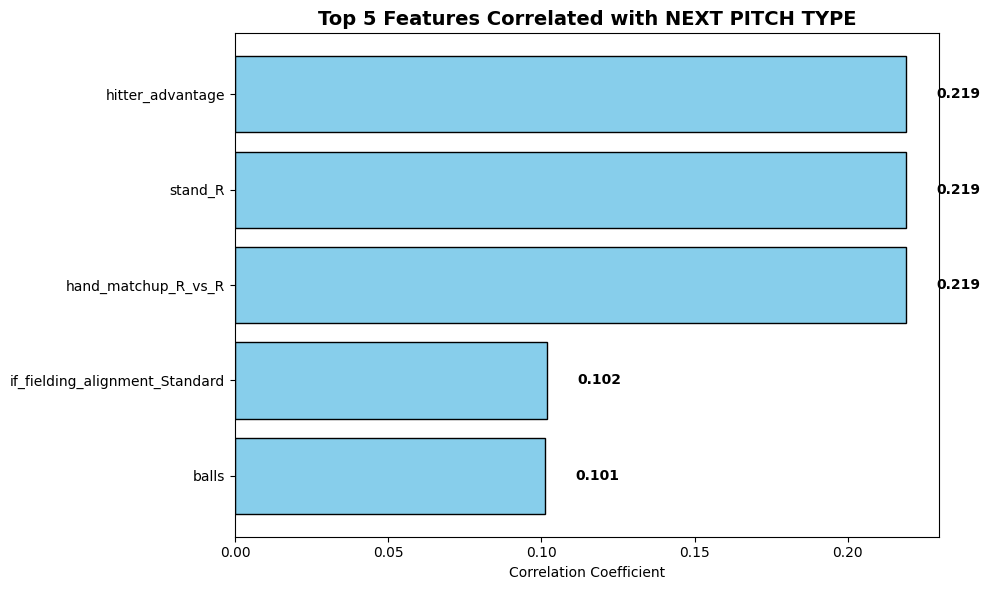

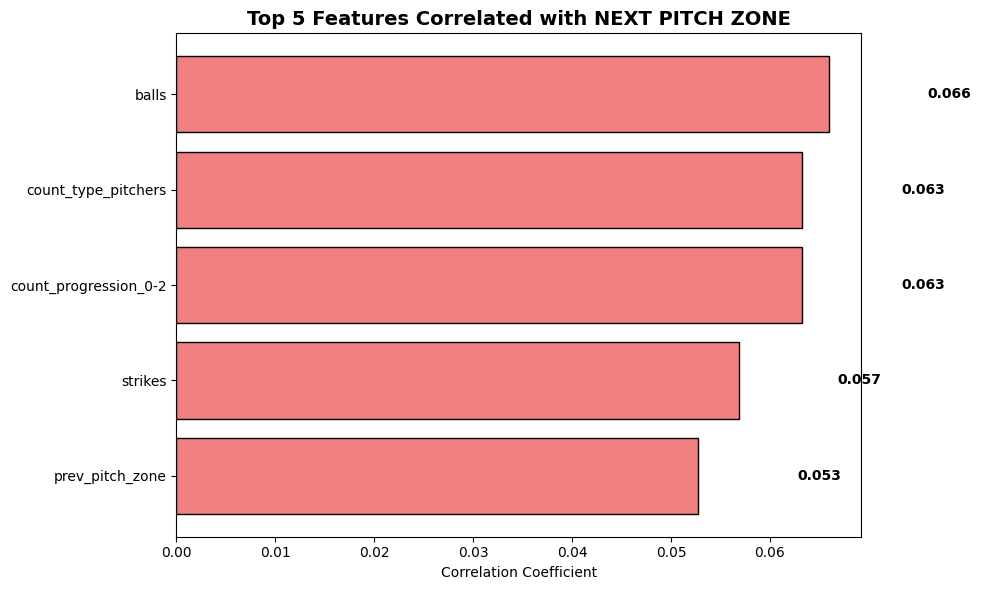

,hand_matchup_R_vs_R,count_progression_0-2,strikes,if_fielding_alignment_Standard,count_type_pitchers,stand_R,balls,prev_pitch_zone,hitter_advantage,next_pitch_type_encoded,next_pitch_zone_encoded
0,False,False,0,False,False,False,0,NaN,1,0,2
1,False,False,1,False,False,False,0,3.0,1,0,1
2,False,True,2,True,True,False,0,3.0,1,1,3
3,False,True,2,False,True,False,0,2.0,1,0,1
4,False,True,2,False,True,False,0,4.0,1,5,9


In [7]:
# Absolute correlation matrix, since we will we be dropping highly correlated features, positve and negative
cm = pitching_data.corr().abs()

# Get correlations with targets
corr_with_pitch = cm['next_pitch_type_encoded'].sort_values(ascending = False)
corr_with_zone = cm['next_pitch_zone_encoded'].sort_values(ascending = False)

# Top correlations with targets
top_pitch_features = corr_with_pitch[~corr_with_pitch.index.isin(['next_pitch_type_encoded', 'next_pitch_zone_encoded'])]
top_zone_features = corr_with_zone[~corr_with_zone.index.isin(['next_pitch_type_encoded', 'next_pitch_zone_encoded'])]

# Get top 5 for each
top5_pitch = top_pitch_features.head(5)
top5_zone = top_zone_features.head(5)

# Next Pitch Type graph
plt.figure(figsize = (10, 6))
bars1 = plt.barh(range(len(top5_pitch)), top5_pitch.values, color = 'skyblue', edgecolor = 'black')
plt.yticks(range(len(top5_pitch)), top5_pitch.index)
plt.xlabel('Correlation Coefficient')
plt.title('Top 5 Features Correlated with NEXT PITCH TYPE', fontsize = 14, fontweight = 'bold')
plt.gca().invert_yaxis()  # Highest correlation at top

# Add correlation values on bars
for i, (bar, val) in enumerate(zip(bars1, top5_pitch.values)):
    plt.text(val + 0.01, i, f'{val:.3f}', va = 'center', fontweight = 'bold')

plt.tight_layout()
plt.show()

# Next Pitch Zone graph
plt.figure(figsize = (10, 6))
bars2 = plt.barh(range(len(top5_zone)), top5_zone.values, color = 'lightcoral', edgecolor = 'black')
plt.yticks(range(len(top5_zone)), top5_zone.index)
plt.xlabel('Correlation Coefficient')
plt.title('Top 5 Features Correlated with NEXT PITCH ZONE', fontsize = 14, fontweight = 'bold')
plt.gca().invert_yaxis()  # Highest correlation at top

# Add correlation values on bars
for i, (bar, val) in enumerate(zip(bars2, top5_zone.values)):
    plt.text(val + 0.01, i, f'{val:.3f}', va = 'center', fontweight = 'bold')

plt.tight_layout()
plt.show()

top_5_pitch = top_pitch_features.head(5).index.tolist()
top_5_zone = top_zone_features.head(5).index.tolist()

# Combine into one list
selected_features = list(set(top_5_pitch + top_5_zone))

selected_features_with_targets = selected_features + ['next_pitch_type_encoded', 'next_pitch_zone_encoded']

# Make new data frame
pitching_data_reduced = pitching_data[selected_features_with_targets].copy()

pitching_data_reduced.head()

# Train/Test Split

In [8]:
y = pitching_data_reduced[['next_pitch_type_encoded', 'next_pitch_zone_encoded']]
X = pitching_data_reduced.drop(['next_pitch_type_encoded', 'next_pitch_zone_encoded'], axis=1)

# Fill remaining NaN values from the new features
X = X.fillna(0)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

# Scale data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train

Pitch type accuracy: 0.410
Zone accuracy: 0.166

Both correct: 0.029


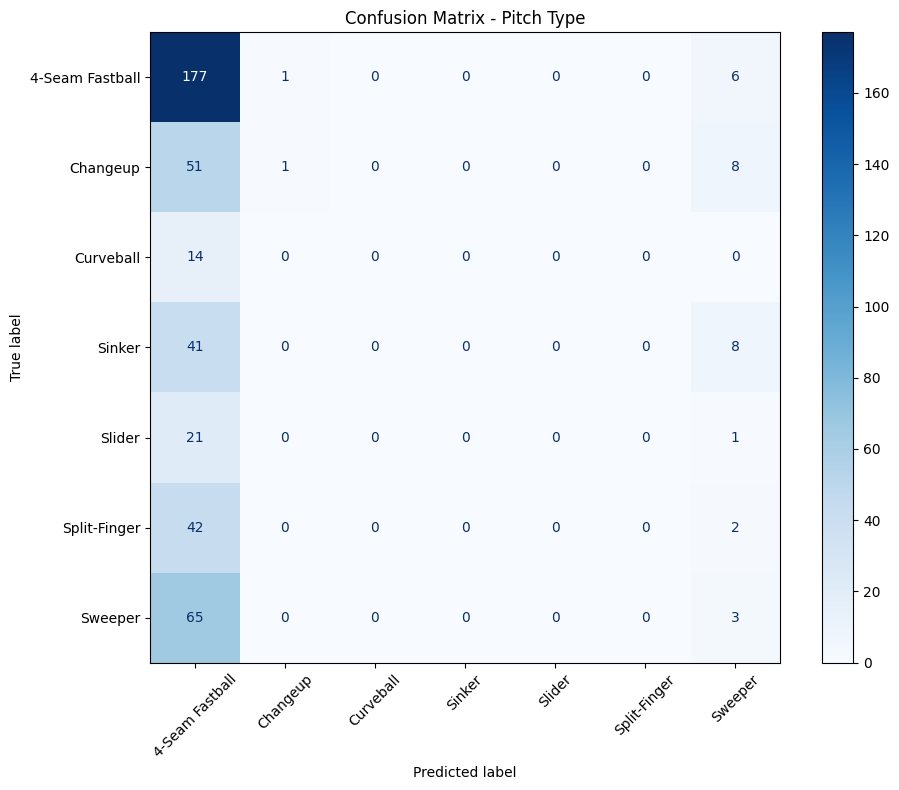

In [9]:
# Model for pitch type
svm_pitch = SVC(kernel = 'rbf', C = 1.0, gamma='scale', random_state = 42, probability = True)
svm_pitch.fit(X_train_scaled, y_train.iloc[:, 0])
y_pred_pitch = svm_pitch.predict(X_test_scaled)
pitch_type_acc = accuracy_score(y_test.iloc[:, 0], y_pred_pitch)
pitch_type_acc = accuracy_score(y_test.iloc[:, 0], y_pred_pitch)
print(f"Pitch type accuracy: {pitch_type_acc:.3f}")
    
# Model for zone
svm_zone = SVC(kernel = 'rbf', C = 1.0, gamma = 'scale', random_state = 42, probability = True)
svm_zone.fit(X_train_scaled, y_train.iloc[:, 1])
y_pred_zone = svm_zone.predict(X_test_scaled)
zone_acc = accuracy_score(y_test.iloc[:, 1], y_pred_zone)
print(f"Zone accuracy: {zone_acc:.3f}")
    
# Combined accuracy
combined_correct = np.mean((y_pred_pitch == y_test.iloc[:, 0]) & (y_pred_zone == y_test.iloc[:, 1]))
print(f"\nBoth correct: {combined_correct:.3f}")

# Confusion matrix for pitching types
cm_pitch = confusion_matrix(y_test.iloc[:, 0], y_pred_pitch) # Normalize by true labels
disp_pitch = ConfusionMatrixDisplay(confusion_matrix = cm_pitch, display_labels = le_pitch.classes_)
fig, ax = plt.subplots(figsize = (10, 8))
disp_pitch.plot(ax = ax, cmap = 'Blues', xticks_rotation = 45)
ax.set_title('Confusion Matrix - Pitch Type')
plt.tight_layout()
plt.show()